In [1]:
# Gerekli kütüphaneler (Yüklü değilse ilk satırı çalıştır)
# !pip install pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [11]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None, usecols=[0,5])
df.columns = ['sentiment', 'text']

# Sadece 0 ve 4 olanları al
df = df[df['sentiment'].isin([0, 4])]

# Her iki sınıftan eşit örnek alalım (örnek: 5000 negatif + 5000 pozitif)
neg = df[df['sentiment'] == 0].sample(5000, random_state=42)
pos = df[df['sentiment'] == 4].sample(5000, random_state=42)
df_balanced = pd.concat([neg, pos])

# Karıştıralım
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Map sentiment labels
df_balanced['sentiment'] = df_balanced['sentiment'].map({0: 0, 4: 1})

df_balanced['sentiment'].value_counts()


sentiment
1    5000
0    5000
Name: count, dtype: int64

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)           # Linkleri kaldır
    text = re.sub(r'@\w+', '', text)              # Kullanıcı adlarını kaldır
    text = re.sub(r'[^a-zA-Z\s]', '', text)       # Sadece harf ve boşluk
    text = re.sub(r'\s+', ' ', text).strip()      # Fazla boşlukları kaldır
    return text

df_balanced['clean_text'] = df_balanced['text'].apply(clean_text)
df_balanced[['text', 'clean_text']].head()


,text,clean_text
0,Found the perfect title for my portfolio. its...,found the perfect title for my portfolio its f...
1,my new anti-virus ive just installed seems to ...,my new antivirus ive just installed seems to b...
2,fact: i still love him...you learn from mistak...,fact i still love himyou learn from mistakes j...
3,i think i gotta make a new twitter account cuz...,i think i gotta make a new twitter account cuz...
4,end of the weekend....back to work tomorrow W...,end of the weekendback to work tomorrow we nee...


In [13]:
X = df_balanced['clean_text']
y = df_balanced['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Eğitim veri sayısı:", len(X_train))
print("Test veri sayısı:", len(X_test))


Eğitim veri sayısı: 8000
Test veri sayısı: 2000


In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [16]:
y_pred = model.predict(X_test_tfidf)

print("Doğruluk oranı:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Pozitif']))


Doğruluk oranı: 0.739
              precision    recall  f1-score   support

     Negatif       0.75      0.74      0.74      1013
     Pozitif       0.73      0.74      0.74       987

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



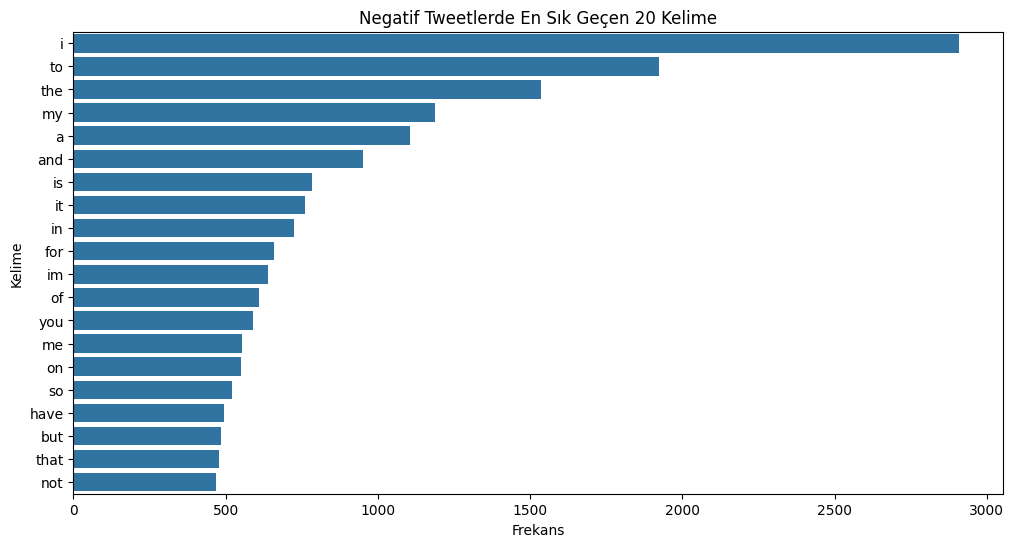

In [17]:
from collections import Counter

neg_words = ' '.join(df_balanced[df_balanced['sentiment'] == 0]['clean_text']).split()
neg_common = Counter(neg_words).most_common(20)

words_neg, counts_neg = zip(*neg_common)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts_neg), y=list(words_neg), orient='h')
plt.title("Negatif Tweetlerde En Sık Geçen 20 Kelime")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.show()


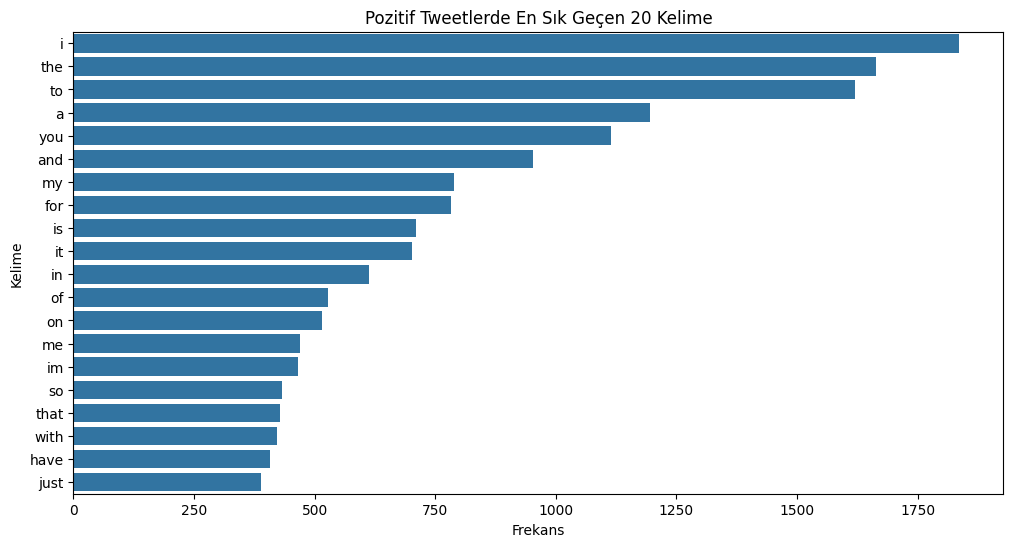

In [18]:
pos_words = ' '.join(df_balanced[df_balanced['sentiment'] == 1]['clean_text']).split()
pos_common = Counter(pos_words).most_common(20)

words_pos, counts_pos = zip(*pos_common)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts_pos), y=list(words_pos), orient='h')
plt.title("Pozitif Tweetlerde En Sık Geçen 20 Kelime")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.show()


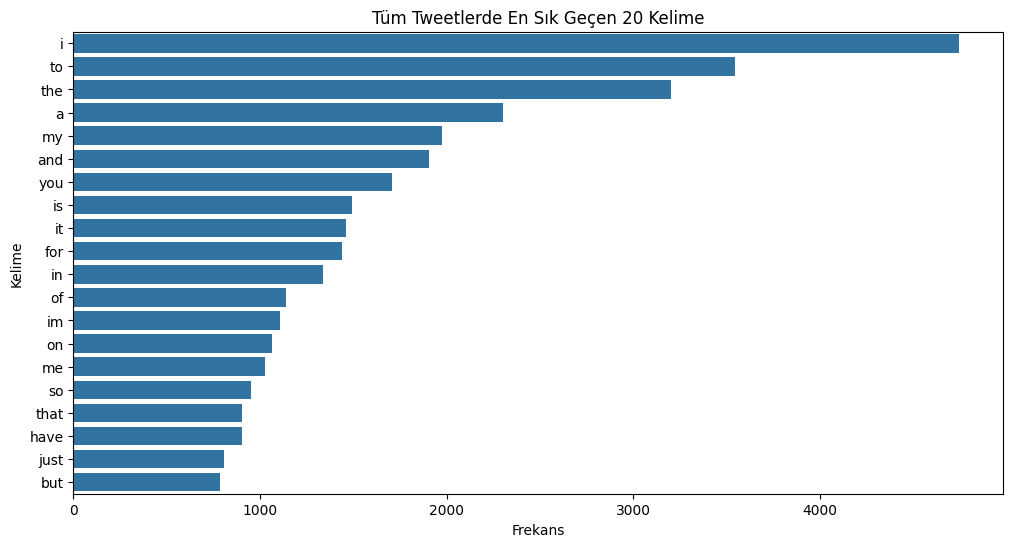

In [19]:
all_words = ' '.join(df_balanced['clean_text']).split()
all_common = Counter(all_words).most_common(20)

words_all, counts_all = zip(*all_common)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts_all), y=list(words_all), orient='h')
plt.title("Tüm Tweetlerde En Sık Geçen 20 Kelime")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.show()
